# Dispersion Analysis: Fornberg vs. DRP Stencils

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from functools import partial
from matplotlib import patheffects
from numpy import linalg as la
import segyio
import sys

In [2]:
from devito import Grid, Function, TimeFunction, SparseTimeFunction, Eq, Operator, solve

In [3]:
normtype  = 2

## 0. Velocity Model

In [4]:
# with segyio.open('velmodels/marmousi.segy') as segyfile:
#     vvel = segyio.tools.cube(segyfile)[0,:,:]
# plt.imshow(np.transpose(vvel))

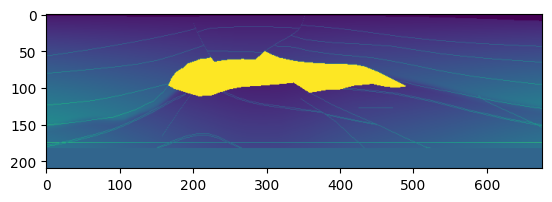

In [5]:
vvel = np.load("velmodels/salt.npy")
plt.imshow(np.transpose(vvel))

## 1. Problem Setup

In [6]:
def ricker(t, f):
    
    val1 = 1-2*((np.pi*f)*(t-1/f))**2
    val2 = -((np.pi*f)**2*(t-1/f)**2)
    val3 = val1*np.exp(val2)

    return val3

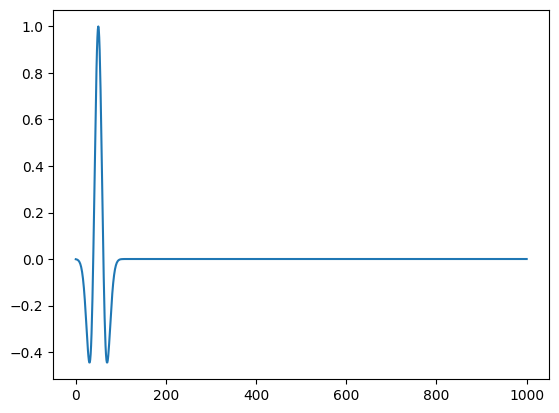

In [7]:
Nsamples = 1000
f = 0.02
t = np.linspace(0, 1000, Nsamples + 1)
rick = ricker(t, f=f)
plt.plot(t,rick)

In [8]:
f0       = 0.02
hx       = 10
hy       = 15
extentx  = hx*vvel.shape[0]
extenty  = hy*vvel.shape[1]
npointsx = vvel.shape[0]
npointsy = vvel.shape[1]
t1       = 1200
vmax     = np.amax(vvel)

In [9]:
def critical_dt(weights,h,vmax):
    
    a = h*np.sqrt(2/np.sum([np.abs(a) for a in weights]))/vmax
    
    return float(a)

In [10]:
def critical_h(weights,dt,vmax):

    a = float(np.sqrt(2/np.sum([np.abs(a) for a in weights]))/(vmax*dt))
    b = 1/a
    
    return b

In [11]:
def acoustic(weightsx,weightsy,hx,hy,dt,vmodel,f,extentx,extenty,t1,factor=1):

    origin = (0., 0.)
    grid_extent = (extentx, extenty)
    snx = int(np.ceil((grid_extent[0] - origin[0])/hx))
    sny = int(np.ceil((grid_extent[1] - origin[1])/hy))
    shape = (snx, sny)
    
    t0 = 0
    tn = int(np.ceil((t1 - t0)/dt))

    vmax = np.amax(vmodel)
    
    r = vmax*dt/min(hx,hy)

    weightsx = np.concatenate([weightsx[::-1], weightsx[1:]])
    weightsy = np.concatenate([weightsy[::-1], weightsy[1:]])
    space_order = len(weightsx) - 1

    sx = grid_extent[0]/2 - origin[0]
    sy = 2*hy

    grid = Grid(shape=shape, extent=grid_extent)
    x, y = grid.dimensions

    velocity = Function(name="velocity", grid=grid, space_order=space_order)
    velocity.data[:] = vmodel[:]

    t = np.linspace(t0, t1, tn)
    source = SparseTimeFunction(
        name="ricker",
        npoint=1,
        coordinates=[(sx, sy)],
        nt=tn,
        grid=grid,
        time_order=2,
        space_order=space_order
    )
    source.data[:, 0] = ricker(t,f=f)

    nrecv = snx + 1
    rx = np.linspace(origin[0], grid_extent[0], nrecv)
    ry = 2*hy*np.ones(nrecv)
    
    receiver = SparseTimeFunction(
        name="recv",
        npoint=nrecv,
        coordinates=np.array([rx, ry]).T,
        nt=tn,
        grid=grid
    )

    u = TimeFunction(name="u", grid=grid, time_order=2, space_order=space_order)

    pde = (1/velocity**2)*u.dt2 - u.dx2(weights=weightsx) - u.dy2(weights=weightsy)
    stencil = Eq(u.forward, solve(pde, u.forward))
    
    src_term = source.inject(field=u.forward, expr=source*factor*factor*velocity*velocity*dt*dt)
    recv_term = receiver.interpolate(expr=u.forward)
    op = Operator([stencil] + src_term + recv_term, subs=grid.spacing_map)
    op(time=tn - 1, dt=dt)
    
    return u.data[-1], receiver.data, r

In [12]:
M = 4
x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
N = 2
weightsteste  = sym.finite_diff_weights(N, x, 0)
fornbergteste = np.array(weightsteste[-1][-1][::2], dtype=np.float64)

In [13]:
dtinitial = critical_dt(fornbergteste,hx,vmax)
dtinitial

1.4594188581304182

In [14]:
uteste,datateste,rteste = acoustic(fornbergteste,fornbergteste,hx,hy,dtinitial,vvel,f0,extentx,extenty,t1)

Operator `Kernel` ran in 0.09 s


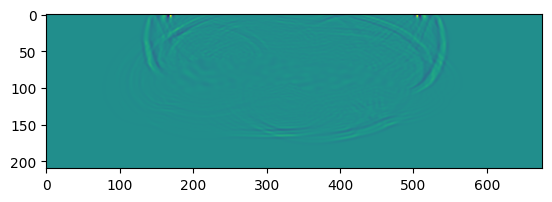

In [15]:
plt.imshow(np.transpose(uteste))

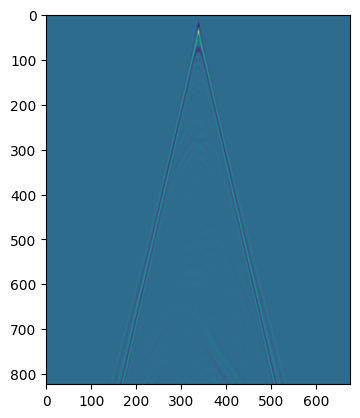

In [16]:
plt.imshow(datateste)

In [17]:
def plot_wave(u, ax, clip, extent, hline,r): 
    extents=(0, extent, 0, extent)
    ax.imshow(
        u.T,
        extent=extents,
        cmap='seismic',
        vmin=-clip,
        vmax=clip
    )
    ax.invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{r = :.3g}')
    len(hline) == 4
    ax.plot(
        (hline[0], hline[2]),
        (hline[1], hline[3]),
        'g--', lw=2
    )

In [18]:
def plot_profile(array,ax,clip,extent,first_arrival):
    
    axis_labels=('x', 'A')
    
    ax.plot(np.linspace(extent[0], extent[1], array.size), array)
    ax.set_xlim(extent)
    ax.set_ylim((-clip, clip))
    ax.set_aspect((extent[1] - extent[0])/(2*clip))
    
    if first_arrival is not None:
        ax.axvline(first_arrival, c='red', ls='--', lw=1)
        ax.annotate(f'first arrival',
            xy=(first_arrival, 0), xycoords='data',
            xytext=(-70, 5), textcoords='offset points', fontsize=12, color='red'
        )
    
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])

In [19]:
def plot_shot(data, ax, clip,extent,t1,vline,r,first_arrival):
    
    extents=(0,extent,0,t1)
    
    ax.imshow(
        data[::-1,:],
        extent=extents,
        vmin=-clip,
        vmax=clip,
        cmap='grey',
        aspect=(extents[1] - extents[0])/(extents[3] - extents[2]),
    )
    ax.invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('t')

    arrival = None
    
    if isinstance(first_arrival, np.ndarray) or first_arrival:
        time = np.linspace(extents[2], extents[3], data.shape[0])
        space = np.linspace(extents[0], extents[1], data.shape[1])
        if not isinstance(first_arrival, np.ndarray):
            arrival = time[np.argmax(np.abs(data)>0.01, axis=0)]
            ax.plot(space, arrival, c='red', lw=1)
            ax.annotate(f'first arrival',
                xy=((extents[1] - extents[0])/2, arrival[arrival.size//2]), xycoords='data',
                xytext=(5, 5), textcoords='offset points', fontsize=12, color='red',
                path_effects=[patheffects.withStroke(linewidth=2, foreground="k")]
            )
        else:
            ax.plot(space, first_arrival, c='red', lw=1)
    
    ax.set_title(f'{r = :.3g}')
    assert len(vline) == 4
    ax.plot(
        (vline[0], vline[2]),
        (vline[1], vline[3]),
        'g--', lw=2
    )
    
    return arrival

In [20]:
h = min(hx,hy)

In [22]:
dtnew1 = critical_dt(fornbergteste,hx/8,vmax)
dtnew1

0.18242735726630227

In [23]:
dtnew = 1.0

In [24]:
M = 10
x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
N = 2
weightsref  = sym.finite_diff_weights(N, x, 0)
fornbergref = np.array(weightsref[-1][-1][::2], dtype=np.float64)

In [26]:
uref,dataref,rref = acoustic(weightsref,weightsref,hx/10,hy/10,dtnew/10,vvel,f,extentx,extenty,t1,factor=10)

ValueError: could not broadcast input array from shape (676,210) into shape (6760,2100)

In [ ]:
sys.exit()

## 2. Fornberg

In [ ]:
u1f,data1f,r1f = acoustic(fornberg,h,dtnew,vval,f0,extent,t1)
u2f,data2f,r2f = acoustic(fornberg,h/2,dtnew,vval,f0,extent,t1)
u3f,data3f,r3f = acoustic(fornberg,h/4,dtnew,vval,f0,extent,t1)
u4f,data4f,r4f = acoustic(fornberg,h/8,dtnew,vval,f0,extent,t1)
u5f,data5f,r5f = acoustic(fornberg,h/16,dtnew,vval,f0,extent,t1)

Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


In [ ]:
luf      = [u1f,u2f,u3f,u4f,u5f]
lrecf    = [data1f,data2f,data3f,data4f,data5f]
lrf      = [r1f,r2f,r3f,r4f,r5f]
luref    = []
ntestes  = len(luf)

In [ ]:
for k0 in range(0,ntestes):

    uloc    = luf[k0]
    ratio   = int(uref.shape[0]/uloc.shape[0])+1
    urefloc = np.zeros((uloc.shape[0],uloc.shape[1]))
    conty   = 0
    
    for k1 in range(0,uloc.shape[1]):

        contx = 0
        
        for k2 in range(0,uloc.shape[0]):

            urefloc[k2,k1] = uref[contx,conty]
            
            contx = contx + ratio

        conty = conty + ratio

    luref.append(urefloc)

In [ ]:
lnormuf   = []
lnormrecf = []

for k0 in range(0,ntestes):
    
    difu   = luref[k0] - luf[k0]
    lnormu = la.norm(difu,2)/la.norm(luref[k0],2)

    difrec   = dataref - lrecf[k0]
    lnormrec = la.norm(difrec,2)/la.norm(dataref,2)

    ctedx = np.sqrt(32/(2**k0))
    ctedt = 1/1
    cte   = ctedt*ctedx
    
    lnormuf.append(cte*lnormu)
    lnormrecf.append(cte*lnormrec)

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(lrf,lnormuf,label='Fornberg')
plt.grid()
plt.legend()
plt.title('Erro for rvalue - M = 4 - Fornberg - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(lrf,lnormrecf,label='Fornberg')
plt.grid()
plt.legend()
plt.title('Erro for rvalue - M = 4 - Fornberg - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

In [ ]:
clipv = 0.01*max(np.amax(uref),np.amax(luf[0]),np.amax(luf[1]),np.amax(luf[2]),np.amax(luf[3]),np.amax(luf[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,5):
    plot_wave(luf[k0], ax[k0],clipv,extent,(0, 500, 500, 500), lrf[k0])

plot_wave(uref,ax[5],clipv,extent,(0, 500, 500, 500), rref)
fig.set_size_inches(24,10)
plt.show()

In [ ]:
clip = max(np.amax(uref),np.amax(luf[0]),np.amax(luf[1]),np.amax(luf[2]),np.amax(luf[3]),np.amax(luf[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,6):

    if(k0==0):

        plot_profile(luf[k0][luf[k0].shape[k0]//2,:luf[k0].shape[1]//2],ax[k0],clip,(0, 500),None)

    elif(k0==5):

        ratio = int(uref.shape[0]/luf[0].shape[0])+1
        plot_profile(uref[uref.shape[0]//ratio, :uref.shape[1]//ratio],ax[k0],clip,(0, 500),None)
        
    else:

        ratio = int(luf[k0].shape[0]/luf[0].shape[0])+1
        plot_profile(luf[k0][luf[k0].shape[0]//ratio,:luf[k0].shape[1]//ratio],ax[k0],clip,(0, 500),None)

fig.set_size_inches(24,10)
plt.show()

In [ ]:
clip    = 0.01*max(np.amax(lrecf[0]),np.amax(lrecf[1]),np.amax(lrecf[2]),np.amax(lrecf[3]),np.amax(lrecf[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 6)
arrival = plot_shot(lrecf[0],ax[0],clip,extent,t1,(500, 0, 500, t1),lrf[0],True)

for k0 in range(1,6):

    if(k0==5):
        
        plot_shot(dataref,ax[k0],clip,extent,t1,(500, 0, 500, t1),rref, arrival)

    else:
        
        plot_shot(lrecf[k0],ax[k0], clip,extent,t1,(500, 0, 500, t1), lrf[k0], arrival)

fig.set_size_inches(24, 10)
plt.show()

In [ ]:
width = lrecf[0].shape[1]
clip = max(np.amax(lrecf[0]),np.amax(lrecf[1]),np.amax(lrecf[2]),np.amax(lrecf[3]),np.amax(lrecf[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 7)
arrival = plot_shot(lrecf[0],ax[6],clip,extent,t1,(500, 0, 500, t1),lrf[0],True)

for k0 in range(0,6):

    if(k0==5):
        
        plot_profile(dataref[:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

    else:

        plot_profile(lrecf[k0][:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

fig.set_size_inches(24, 10)
plt.show()

## 3. DPRS - Method 1

In [ ]:
initial_guess = fornberg

constraints = [{
    'type': 'eq',
    'fun': lambda x: x[0] + 2*np.sum(x[1:])
}]
constraints += [{
    'type': 'eq',
    'fun': lambda x: np.sum([xi*m**2 for m, xi in enumerate(x)]) - 1
}]
constraints += [{
    'type': 'eq',
    'fun': lambda x: np.sum([xi*m**(2*jj) for m, xi in enumerate(x)])
} for jj in range(2, (len(initial_guess) + 1)//2)]

In [ ]:
def objective(a):
    x = np.linspace(0, np.pi/2, 201)
    m = np.arange(1, len(a) + 1)
    y = x**2 + a[0] + 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(a[1:], m)], axis=0)
    return sp.integrate.trapezoid(y**2, x=x)

In [ ]:
opt1 = sp.optimize.minimize(objective, initial_guess, method='SLSQP', constraints=constraints, options=dict(ftol=1e-15, maxiter=500))
drp_stencil1 = opt1.x

In [ ]:
u1drp1,data1drp1,r1drp1 = acoustic(drp_stencil1,h,dtnew,vval,f0,extent,t1)
u2drp1,data2drp1,r2drp1 = acoustic(drp_stencil1,h/2,dtnew,vval,f0,extent,t1)
u3drp1,data3drp1,r3drp1 = acoustic(drp_stencil1,h/4,dtnew,vval,f0,extent,t1)
u4drp1,data4drp1,r4drp1 = acoustic(drp_stencil1,h/8,dtnew,vval,f0,extent,t1)
u5drp1,data5drp1,r5drp1 = acoustic(drp_stencil1,h/16,dtnew,vval,f0,extent,t1)

In [ ]:
ludrp1      = [u1drp1,u2drp1,u3drp1,u4drp1,u5drp1]
lrecdrp1    = [data1drp1,data2drp1,data3drp1,data4drp1,data5drp1]
lrdrp1      = [r1drp1,r2drp1,r3drp1,r4drp1,r5drp1]

lnormudrp1   = []
lnormrecdrp1 = []

for k0 in range(0,ntestes):
    
    difu   = luref[k0] - ludrp1[k0]
    lnormu = la.norm(difu,2)/la.norm(luref[k0],2)

    difrec   = dataref - lrecdrp1[k0]
    lnormrec = la.norm(difrec,2)/la.norm(dataref,2)
    
    ctedx = np.sqrt(32/(2**k0))
    ctedt = 1/1
    cte   = ctedt*ctedx

    lnormudrp1.append(cte*lnormu)
    lnormrecdrp1.append(cte*lnormrec)

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(lrdrp1,lnormudrp1,label='DRP1')
plt.grid()
plt.legend()
plt.title('Erro for rvalue - M = 4 - DRP1 - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(lrdrp1,lnormrecdrp1,label='DRP1')
plt.grid()
plt.legend()
plt.title('Erro for rvalue - M = 4 - DRP1 - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')

In [ ]:
clipv = 0.01*max(np.amax(uref),np.amax(ludrp1[0]),np.amax(ludrp1[1]),np.amax(ludrp1[2]),np.amax(ludrp1[3]),np.amax(ludrp1[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,5):
    plot_wave(ludrp1[k0], ax[k0],clipv,extent,(0, 500, 500, 500), lrdrp1[k0])

plot_wave(uref,ax[5],clipv,extent,(0, 500, 500, 500), rref)
fig.set_size_inches(24,10)
plt.show()

In [ ]:
clip = max(np.amax(uref),np.amax(ludrp1[0]),np.amax(ludrp1[1]),np.amax(ludrp1[2]),np.amax(ludrp1[3]),np.amax(ludrp1[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,6):

    if(k0==0):

        plot_profile(ludrp1[k0][ludrp1[k0].shape[k0]//2,:ludrp1[k0].shape[1]//2],ax[k0],clip,(0, 500),None)

    elif(k0==5):

        ratio = int(uref.shape[0]/ludrp1[0].shape[0])+1
        plot_profile(uref[uref.shape[0]//ratio, :uref.shape[1]//ratio],ax[k0],clip,(0, 500),None)
        
    else:

        ratio = int(ludrp1[k0].shape[0]/ludrp1[0].shape[0])+1
        plot_profile(ludrp1[k0][ludrp1[k0].shape[0]//ratio,:ludrp1[k0].shape[1]//ratio],ax[k0],clip,(0, 500),None)

fig.set_size_inches(24,10)
plt.show()

In [ ]:
clip    = 0.01*max(np.amax(lrecdrp1[0]),np.amax(lrecdrp1[1]),np.amax(lrecdrp1[2]),np.amax(lrecdrp1[3]),np.amax(lrecdrp1[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 6)
arrival = plot_shot(lrecdrp1[0],ax[0],clip,extent,t1,(500, 0, 500, t1),lrdrp1[0],True)

for k0 in range(1,6):

    if(k0==5):
        
        plot_shot(dataref,ax[k0],clip,extent,t1,(500, 0, 500, t1),rref, arrival)

    else:
        
        plot_shot(lrecdrp1[k0],ax[k0], clip,extent,t1,(500, 0, 500, t1), lrdrp1[k0], arrival)

fig.set_size_inches(24, 10)
plt.show()

In [ ]:
width = lrecf[0].shape[1]
clip = max(np.amax(lrecdrp1[0]),np.amax(lrecdrp1[1]),np.amax(lrecdrp1[2]),np.amax(lrecdrp1[3]),np.amax(lrecdrp1[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 7)
arrival = plot_shot(lrecdrp1[0],ax[6],clip,extent,t1,(500, 0, 500, t1),lrf[0],True)

for k0 in range(0,6):

    if(k0==5):
        
        plot_profile(dataref[:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

    else:

        plot_profile(lrecdrp1[k0][:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

fig.set_size_inches(24, 10)
plt.show()

## 4.DRPS - Method 2

In [ ]:
def dispersion_difference(weights, h, dt, v, k, alpha):
    if k == 0:
        diff = 0
    else:
        m = len(weights)
        cosines = np.array([
            np.cos(m*k*h*np.cos(alpha)) + np.cos(m*k*h*np.sin(alpha)) - 2
            for m in range(1, m)
        ])
        total = np.sum(np.array(weights)[1:]*cosines)
        theta = 1 + (v**2)*(dt**2)*total/(h**2)
        diff = np.abs(np.acos(theta)/(k*dt) - v)
    return diff

In [ ]:
def objective2(a, h, dt, fmax=100, vmin=1500, vmax=5500, alphamin=0, alphamax=np.pi/4, res=31):
    diff_wrapper = partial(dispersion_difference, weights=a, h=h, dt=dt)

    k_integral = np.zeros(res)
    v_space = np.linspace(vmin, vmax, res)
    alpha_space = np.linspace(alphamin, alphamax, res)
    for ii, v in enumerate(v_space):
        alpha_integral = np.zeros(res)
        k_space = np.linspace(0, 2*np.pi*fmax/v, res)
        for jj, k in enumerate(k_space):
            alpha_data = np.array([
                diff_wrapper(alpha=alpha, k=k, v=v) for alpha in alpha_space
            ])
            alpha_integral[jj] = np.trapezoid(alpha_data, alpha_space)
        k_integral[ii] = np.trapezoid(alpha_integral, k_space)
    v_integral = np.trapezoid(k_integral, v_space)

    return v_integral

In [ ]:
vh           = [h,h/2,h/4,h/8,h/16]
vstencildrp2 = []
nvh          = len(vh)
vdtcritical  = []

for k0 in range(0,nvh):
    hloc = vh[k0]
    objective2_wrapper = partial(objective2, h=hloc, dt=dtnew)
    opt2 = sp.optimize.minimize(objective2_wrapper, initial_guess, constraints=constraints, method='SLSQP')
    drp_stencil2 = opt2.x
    vstencildrp2.append(drp_stencil2)
    vdtcritical.append(critical_dt(drp_stencil2,hloc,vval))

In [ ]:
u1drp2,data1drp2,r1drp2 = acoustic(vstencildrp2[0],h,dtnew,vval,f0,extent,t1)
u2drp2,data2drp2,r2drp2 = acoustic(vstencildrp2[1],h/2,dtnew,vval,f0,extent,t1)
u3drp2,data3drp2,r3drp2 = acoustic(vstencildrp2[2],h/4,dtnew,vval,f0,extent,t1)
u4drp2,data4drp2,r4drp2 = acoustic(vstencildrp2[3],h/8,dtnew,vval,f0,extent,t1)
u5drp2,data5drp2,r5drp2 = acoustic(vstencildrp2[4],h/16,dtnew,vval,f0,extent,t1)

In [ ]:
ludrp2      = [u1drp2,u2drp2,u3drp2,u4drp2,u5drp2]
lrecdrp2    = [data1drp2,data2drp2,data3drp2,data4drp2,data5drp2]
lrdrp2      = [r1drp2,r2drp2,r3drp2,r4drp2,r5drp2]

lnormudrp2   = []
lnormrecdrp2 = []

for k0 in range(0,ntestes):
    
    difu   = luref[k0] - ludrp2[k0]
    lnormu = la.norm(difu,2)/la.norm(luref[k0],2)

    difrec   = dataref - lrecdrp2[k0]
    lnormrec = la.norm(difrec,2)/la.norm(dataref,2)
    
    ctedx = np.sqrt(32/(2**k0))
    ctedt = 1/1
    cte   = ctedt*ctedx

    lnormudrp2.append(cte*lnormu)
    lnormrecdrp2.append(cte*lnormrec)

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(lrdrp2,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for rvalue - M = 4 - DRP2 - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(lrdrp2,lnormrecdrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for rvalue - M = 4 - DRP2 - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')

In [ ]:
clipv = 0.01*max(np.amax(uref),np.amax(ludrp2[0]),np.amax(ludrp2[1]),np.amax(ludrp2[2]),np.amax(luf[3]),np.amax(ludrp2[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,5):
    plot_wave(ludrp2[k0], ax[k0],clipv,extent,(0, 500, 500, 500), lrdrp2[k0])

plot_wave(uref,ax[5],clipv,extent,(0, 500, 500, 500), rref)
fig.set_size_inches(24,10)
plt.show()

In [ ]:
clip = max(np.amax(uref),np.amax(ludrp2[0]),np.amax(ludrp2[1]),np.amax(ludrp2[2]),np.amax(ludrp2[3]),np.amax(ludrp2[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,6):

    if(k0==0):

        plot_profile(ludrp2[k0][ludrp2[k0].shape[k0]//2,:ludrp2[k0].shape[1]//2],ax[k0],clip,(0, 500),None)

    elif(k0==5):

        ratio = int(uref.shape[0]/ludrp2[0].shape[0])+1
        plot_profile(uref[uref.shape[0]//ratio, :uref.shape[1]//ratio],ax[k0],clip,(0, 500),None)
        
    else:

        ratio = int(ludrp2[k0].shape[0]/ludrp2[0].shape[0])+1
        plot_profile(ludrp2[k0][ludrp2[k0].shape[0]//ratio,:ludrp2[k0].shape[1]//ratio],ax[k0],clip,(0, 500),None)

fig.set_size_inches(24,10)
plt.show()

In [ ]:
clip    = 0.01*max(np.amax(lrecdrp2[0]),np.amax(lrecdrp2[1]),np.amax(lrecdrp2[2]),np.amax(lrecdrp2[3]),np.amax(lrecdrp2[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 6)
arrival = plot_shot(lrecdrp2[0],ax[0],clip,extent,t1,(500, 0, 500, t1),lrdrp2[0],True)

for k0 in range(1,6):

    if(k0==5):
        
        plot_shot(dataref,ax[k0],clip,extent,t1,(500, 0, 500, t1),rref, arrival)

    else:
        
        plot_shot(lrecdrp2[k0],ax[k0], clip,extent,t1,(500, 0, 500, t1), lrdrp2[k0], arrival)

fig.set_size_inches(24, 10)
plt.show()

In [ ]:
width = lrecf[0].shape[1]
clip = max(np.amax(lrecdrp2[0]),np.amax(lrecdrp2[1]),np.amax(lrecdrp2[2]),np.amax(lrecdrp2[3]),np.amax(lrecdrp2[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 7)
arrival = plot_shot(lrecdrp2[0],ax[6],clip,extent,t1,(500, 0, 500, t1),lrdrp2[0],True)

for k0 in range(0,6):

    if(k0==5):
        
        plot_profile(dataref[:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

    else:

        plot_profile(lrecdrp2[k0][:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

fig.set_size_inches(24, 10)
plt.show()

## 5. Comparison

In [ ]:
lnormuf

In [ ]:
lnormudrp1

In [ ]:
lnormudrp2

In [ ]:
np.array(lnormuf)-np.array(lnormudrp1)

In [ ]:
np.array(lnormuf)-np.array(lnormudrp2)

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(lrf,lnormuf,label='Fornberg')
plt.plot(lrdrp1,lnormudrp1,label='DRP1')
plt.plot(lrdrp2,lnormudrp1,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for rvalue - M = 4 - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()

In [ ]:
lnormrecf

In [ ]:
lnormrecdrp1

In [ ]:
lnormrecdrp2

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(lrf,lnormrecf,label='Fornberg')
plt.plot(lrdrp1,lnormrecdrp1,label='DRP1')
plt.plot(lrdrp2,lnormrecdrp1,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for rvalue - M = 4 - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()

In [ ]:
clipv = 0.01*max(np.amax(uref),np.amax(luf[0]),np.amax(luf[1]),np.amax(luf[2]),np.amax(luf[3]),np.amax(luf[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,5):
    plot_wave(luf[k0], ax[k0],clipv,extent,(0, 500, 500, 500), lrf[k0])

plot_wave(uref,ax[5],clipv,extent,(0, 500, 500, 500), rref)
fig.set_size_inches(24,10)
plt.show()

clipv = 0.01*max(np.amax(uref),np.amax(ludrp1[0]),np.amax(ludrp1[1]),np.amax(ludrp1[2]),np.amax(ludrp1[3]),np.amax(ludrp1[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,5):
    plot_wave(ludrp1[k0], ax[k0],clipv,extent,(0, 500, 500, 500), lrdrp1[k0])

plot_wave(uref,ax[5],clipv,extent,(0, 500, 500, 500), rref)
fig.set_size_inches(24,10)
plt.show()

clipv = 0.01*max(np.amax(uref),np.amax(ludrp2[0]),np.amax(ludrp2[1]),np.amax(ludrp2[2]),np.amax(luf[3]),np.amax(ludrp2[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,5):
    plot_wave(ludrp2[k0], ax[k0],clipv,extent,(0, 500, 500, 500), lrdrp2[k0])

plot_wave(uref,ax[5],clipv,extent,(0, 500, 500, 500), rref)
fig.set_size_inches(24,10)
plt.show()

In [ ]:
clip = max(np.amax(uref),np.amax(luf[0]),np.amax(luf[1]),np.amax(luf[2]),np.amax(luf[3]),np.amax(luf[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,6):

    if(k0==0):

        plot_profile(luf[k0][luf[k0].shape[k0]//2,:luf[k0].shape[1]//2],ax[k0],clip,(0, 500),None)

    elif(k0==5):

        ratio = int(uref.shape[0]/luf[0].shape[0])+1
        plot_profile(uref[uref.shape[0]//ratio, :uref.shape[1]//ratio],ax[k0],clip,(0, 500),None)
        
    else:

        ratio = int(luf[k0].shape[0]/luf[0].shape[0])+1
        plot_profile(luf[k0][luf[k0].shape[0]//ratio,:luf[k0].shape[1]//ratio],ax[k0],clip,(0, 500),None)

fig.set_size_inches(24,10)
plt.show()

clip = max(np.amax(uref),np.amax(ludrp1[0]),np.amax(ludrp1[1]),np.amax(ludrp1[2]),np.amax(ludrp1[3]),np.amax(ludrp1[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,6):

    if(k0==0):

        plot_profile(ludrp1[k0][ludrp1[k0].shape[k0]//2,:ludrp1[k0].shape[1]//2],ax[k0],clip,(0, 500),None)

    elif(k0==5):

        ratio = int(uref.shape[0]/ludrp1[0].shape[0])+1
        plot_profile(uref[uref.shape[0]//ratio, :uref.shape[1]//ratio],ax[k0],clip,(0, 500),None)
        
    else:

        ratio = int(ludrp1[k0].shape[0]/ludrp1[0].shape[0])+1
        plot_profile(ludrp1[k0][ludrp1[k0].shape[0]//ratio,:ludrp1[k0].shape[1]//ratio],ax[k0],clip,(0, 500),None)

fig.set_size_inches(24,10)
plt.show()

clip = max(np.amax(uref),np.amax(ludrp2[0]),np.amax(ludrp2[1]),np.amax(ludrp2[2]),np.amax(ludrp2[3]),np.amax(ludrp2[4]))
fig, ax = plt.subplots(1, 6)
for k0 in range(0,6):

    if(k0==0):

        plot_profile(ludrp2[k0][ludrp2[k0].shape[k0]//2,:ludrp2[k0].shape[1]//2],ax[k0],clip,(0, 500),None)

    elif(k0==5):

        ratio = int(uref.shape[0]/ludrp2[0].shape[0])+1
        plot_profile(uref[uref.shape[0]//ratio, :uref.shape[1]//ratio],ax[k0],clip,(0, 500),None)
        
    else:

        ratio = int(ludrp2[k0].shape[0]/ludrp2[0].shape[0])+1
        plot_profile(ludrp2[k0][ludrp2[k0].shape[0]//ratio,:ludrp2[k0].shape[1]//ratio],ax[k0],clip,(0, 500),None)

fig.set_size_inches(24,10)
plt.show()

In [ ]:
clip    = 0.01*max(np.amax(lrecf[0]),np.amax(lrecf[1]),np.amax(lrecf[2]),np.amax(lrecf[3]),np.amax(lrecf[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 6)
arrival = plot_shot(lrecf[0],ax[0],clip,extent,t1,(500, 0, 500, t1),lrf[0],True)

for k0 in range(1,6):

    if(k0==5):
        
        plot_shot(dataref,ax[k0],clip,extent,t1,(500, 0, 500, t1),rref, arrival)

    else:
        
        plot_shot(lrecf[k0],ax[k0], clip,extent,t1,(500, 0, 500, t1), lrf[k0], arrival)

fig.set_size_inches(24, 10)
plt.show()

clip    = 0.01*max(np.amax(lrecdrp1[0]),np.amax(lrecdrp1[1]),np.amax(lrecdrp1[2]),np.amax(lrecdrp1[3]),np.amax(lrecdrp1[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 6)
arrival = plot_shot(lrecdrp1[0],ax[0],clip,extent,t1,(500, 0, 500, t1),lrdrp1[0],True)

for k0 in range(1,6):

    if(k0==5):
        
        plot_shot(dataref,ax[k0],clip,extent,t1,(500, 0, 500, t1),rref, arrival)

    else:
        
        plot_shot(lrecdrp1[k0],ax[k0], clip,extent,t1,(500, 0, 500, t1), lrdrp1[k0], arrival)

fig.set_size_inches(24, 10)
plt.show()

clip    = 0.01*max(np.amax(lrecdrp2[0]),np.amax(lrecdrp2[1]),np.amax(lrecdrp2[2]),np.amax(lrecdrp2[3]),np.amax(lrecdrp2[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 6)
arrival = plot_shot(lrecdrp2[0],ax[0],clip,extent,t1,(500, 0, 500, t1),lrdrp2[0],True)

for k0 in range(1,6):

    if(k0==5):
        
        plot_shot(dataref,ax[k0],clip,extent,t1,(500, 0, 500, t1),rref, arrival)

    else:
        
        plot_shot(lrecdrp2[k0],ax[k0], clip,extent,t1,(500, 0, 500, t1), lrdrp2[k0], arrival)

fig.set_size_inches(24, 10)
plt.show()

In [ ]:
width = lrecf[0].shape[1]
clip = max(np.amax(lrecf[0]),np.amax(lrecf[1]),np.amax(lrecf[2]),np.amax(lrecf[3]),np.amax(lrecf[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 7)
arrival = plot_shot(lrecf[0],ax[6],clip,extent,t1,(500, 0, 500, t1),lrf[0],True)

for k0 in range(0,6):

    if(k0==5):
        
        plot_profile(dataref[:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

    else:

        plot_profile(lrecf[k0][:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

fig.set_size_inches(24, 10)
plt.show()

width = lrecf[0].shape[1]
clip = max(np.amax(lrecdrp1[0]),np.amax(lrecdrp1[1]),np.amax(lrecdrp1[2]),np.amax(lrecdrp1[3]),np.amax(lrecdrp1[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 7)
arrival = plot_shot(lrecdrp1[0],ax[6],clip,extent,t1,(500, 0, 500, t1),lrf[0],True)

for k0 in range(0,6):

    if(k0==5):
        
        plot_profile(dataref[:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

    else:

        plot_profile(lrecdrp1[k0][:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

fig.set_size_inches(24, 10)
plt.show()

width = lrecf[0].shape[1]
clip = max(np.amax(lrecdrp2[0]),np.amax(lrecdrp2[1]),np.amax(lrecdrp2[2]),np.amax(lrecdrp2[3]),np.amax(lrecdrp2[4]),np.amax(dataref))
fig, ax = plt.subplots(1, 7)
arrival = plot_shot(lrecdrp2[0],ax[6],clip,extent,t1,(500, 0, 500, t1),lrdrp2[0],True)

for k0 in range(0,6):

    if(k0==5):
        
        plot_profile(dataref[:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

    else:

        plot_profile(lrecdrp2[k0][:,width//2],ax[k0],clip,(0,t1),arrival[width//2])

fig.set_size_inches(24, 10)
plt.show()